In [2]:
%load_ext autoreload
%autoreload 2

import sys
import os
import sklearn
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from osgeo import gdal
from matplotlib import patches as mpl_patches
from matplotlib.colors import Colormap
from mpl_toolkits.mplot3d import Axes3D
from sklearn.manifold import TSNE, Isomap, SpectralEmbedding
from sklearn import cluster, decomposition
from sklearn.cluster import SpectralClustering, KMeans, AgglomerativeClustering, AffinityPropagation

sys.path.insert(1, os.path.join(sys.path[0], ".."))
sys.path.append('../../')
from reproduction import analysis
from reproduction.models import autoencoder
from reproduction.pipeline import load as pipeline
from reproduction.analysis import AEData, plot_cluster_channel_distributions, get_tif_metadata
from reproduction.analysis import plot_cluster_samples, plot_all_cluster_samples

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
model_dir = "/home/rlourenco/rdcep_clouds/output/m9-22_oceans/"

def load_model(model_dir, name):
    with open(model_dir + name + ".json", "r") as f:
        model = tf.keras.models.model_from_json(f.read())
    model.load_weights(model_dir + name + ".h5")
    return model

encoder = load_model(model_dir, "encoder")
decoder = load_model(model_dir, "decoder")
# encoder, decoder = autoencoder(shape=(None, None, 7), data_format="channels_last")

encoder.load_weights(model_dir + "encoder.h5")
decoder.load_weights(model_dir + "decoder.h5")

/home/rlourenco/miniconda3/envs/clouds-analysis-cpu/lib/python3.6/site-packages/tensorflow/python/keras/layers/core.py:764: UserWarning: models is not loaded, but a Lambda layer uses it. It may cause errors.
  , UserWarning)


In [4]:
SHAPE = 128, 128, 7

# Clustering one example swath

In [10]:
swath_tif = gdal.Open("/project/foster/clouds/data/2015_05/reference_tif/2017-01-31_MOD09GA_background_removal_zero_inputated_image_with_cf_50perc_grid_size10-0000000000-0000052992.tif")
print(swath_tif.RasterYSize, swath_tif.RasterYSize)


17664 17664


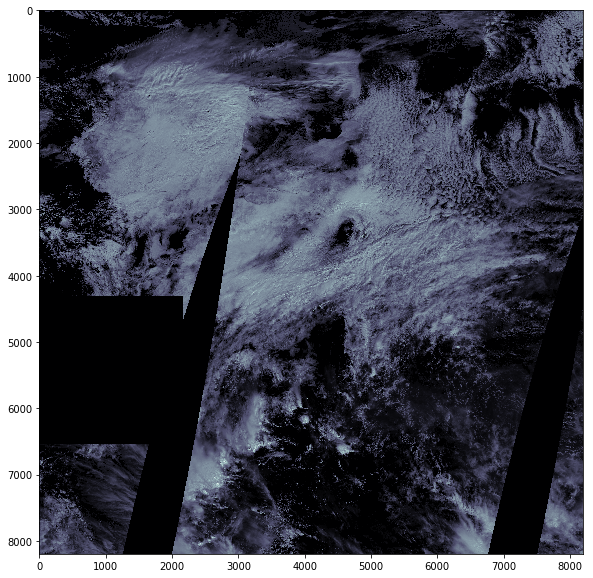

In [12]:
%matplotlib inline

swath = swath_tif.ReadAsArray(xoff=9400, yoff=4600, xsize=8196, ysize=8196)#(xoff=2600, yoff=3000, xsize=2048, ysize=3072)
swath = np.rollaxis(swath, 0, 3)
plt.figure(figsize=(10, 10))
plt.imshow(swath[:,:,0], cmap="bone")

In [13]:
swath_mean = swath.mean(axis=(0,1))
swath_std = swath.std(axis=(0,1))
patches = []

stride = 128
patch_size = 128

patches = []
for i in range(0, swath.shape[0], stride):
    row = []
    for j in range(0, swath.shape[1], stride):
        if i + patch_size <= swath.shape[0] and j + patch_size <= swath.shape[1]:
            p = swath[i:i + patch_size, j:j + patch_size].astype(float)
            p -= swath_mean
            p /= swath_std
            
            row.append(p)
    if row:
        patches.append(row)
            
patches = np.stack(patches)

In [14]:
_encs = encoder.predict(patches.reshape((-1, 128, 128, 7)))
color_map = ["c%d"%i for i in range(10)]

In [15]:
method = SpectralClustering(6, affinity="rbf")
# method = AffinityPropagation()
features = _encs.mean(axis=(1,2))

In [16]:
patches_labels = method.fit_predict(features).reshape(patches.shape[:2])

In [17]:
# colors = plt.cm.plasma_r(patches_labels / patches_labels.max())
colors = [
    "yellow",
    "red",
    "blue",
    "magenta",
    "cyan",
    "green",
    "black"
]

In [18]:
patches_labels.shape, patches.shape

((64, 64), (64, 64, 128, 128, 7))

In [19]:
colors

['yellow', 'red', 'blue', 'magenta', 'cyan', 'green', 'black']

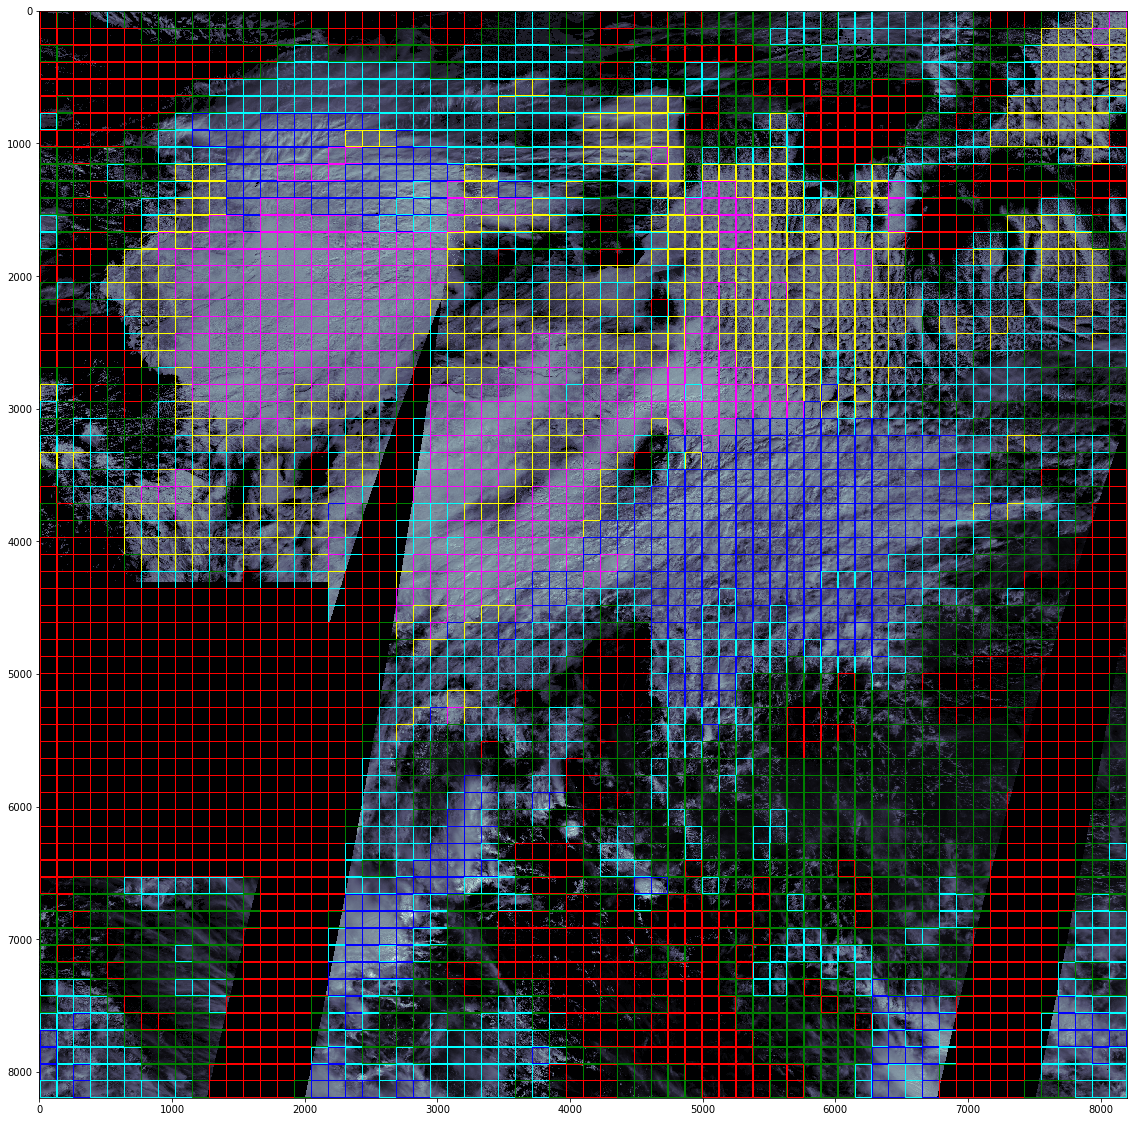

In [20]:
%matplotlib inline
line_width = 1

fig, a = plt.subplots(figsize=(20,20))
plt.imshow(swath[:,:,0], cmap="bone")
rects = []
for i in range(patches.shape[0]):
    for j in range(patches.shape[1]):
        a.add_patch(mpl_patches.Rectangle(
            (j * SHAPE[0] + line_width , i * SHAPE[1] + line_width ),
            width=SHAPE[0] - line_width * 2,
            height=SHAPE[1] - line_width * 2,
            linewidth=line_width,
            edgecolor=colors[patches_labels[i,j]],
            facecolor="none"
        ))

In [2]:
s1 = np.expand_dims((swath - swath_mean)/ swath_std, 0) 

NameError: name 'np' is not defined

In [ ]:
e1 = encoder.predict(s1)
_, ax = plt.subplots(16, 8, figsize=(20,40))

for i, a in enumerate(ax.ravel()):
    a.set_xticks([])
    a.set_yticks([])
    a.imshow(e1[0,:,:,i], cmap="bone")


In [ ]:
vecs = e1.reshape((-1, 128))

In [1]:
centered = vecs - vecs.mean(axis=0)
cov = centered.transpose().dot(centered) / centered.shape[0]
evals, evecs = np.linalg.eigh(cov)
evals = np.flip(evals)
evecs = np.flip(evecs, axis=1)

NameError: name 'vecs' is not defined

In [ ]:
pca = centered.dot(evecs).reshape((*e1.shape[1:3], -1))

In [ ]:
pca.max(axis=(0,1)).shape

In [ ]:
pca /= pca.max(axis=(0,1)) - pca.min(axis=(0,1))
pca -= pca.min(axis=(0,1))

In [ ]:
nrows, ncols = 2, 4
width = 4
fig, ax = plt.subplots(nrows, ncols, figsize=(ncols * width, nrows * width))
for i, a in enumerate(ax.ravel()):
    if i < 7:
        a.imshow(swath[:,:,i], cmap="bone")
    a.set_xticks([])
    a.set_yticks([])
fig.tight_layout()

In [ ]:
nrows, ncols = 4, 5
width = 4

fig, ax = plt.subplots(nrows, ncols, figsize=(ncols * width, nrows * width))

for i, a in enumerate(ax.ravel()):
    a.imshow(pca[:,:,i], cmap="bone")
    a.set_xticks([])
    a.set_yticks([])
fig.tight_layout()

In [ ]:
e1.shape

In [ ]:
h, w, c = swath.shape

z = swath.reshape((h // 16, 16, w // 16, 16, c))

dumb_vecs = np.stack(
    [
        z.mean(axis=(1,3,4)),
        z.std(axis=(1,3,4))
    ],
    axis=2
)

In [ ]:
# from tensorflow.keras.applications.densenet import DenseNet121
# dnet = DenseNet121(include_top=False)

In [ ]:
s2 = analysis.cmap_and_normalize(swath)
# dn_vectors = dnet.predict(s2)

In [ ]:
n_clusters = 10

method = cluster.AgglomerativeClustering(
    n_clusters,
)

In [ ]:
pv_labels = method.fit_predict(e1.reshape((-1, 128)))

In [ ]:
dv_labels = method.fit_predict(dumb_vecs.reshape((-1, 2)))

In [ ]:
dumb_vecs.shape

In [ ]:
# dn_labels = SpectralClustering(6, affinity="nearest_neighbors").fit_predict(dn_vectors.reshape((-1, 1024)))

In [ ]:
_, ((a, b), (c, d)) = plt.subplots(2, 2, figsize=(15,15))

a.imshow(pv_labels.reshape(e1.shape[1:3]), cmap=plt.cm.tab10)
a.set_title("bottleneck features")

# b.imshow(swath[:,:,0], cmap="bone")
b.imshow(s2[0])
b.set_title("original")

c.imshow(dv_labels.reshape(dumb_vecs.shape[0:2]), cmap=plt.cm.tab10)
c.set_title("mean-std features")

# d.imshow(dn_labels.reshape(64, 64), cmap=plt.cm.tab10)
# d.set_title("densenet features")

plt.suptitle(method);

In [ ]:
encoder

# Clustering many random patches

In [ ]:
SHAPE = 128, 128, 7

data = AEData(pipeline.load_data("../data/tif/*.tfrecord", SHAPE, flips=False), n=3000)

In [ ]:
data.raw_encs = encoder.predict(data.imgs)
data.encs = data.raw_encs.mean(axis=(1,2))

In [ ]:
data.ae_imgs = decoder.predict(data.raw_encs)

In [ ]:
?mixture.BayesianGaussianMixture

In [ ]:
from sklearn import mixture
n_clusters = 20
gmm = mixture.BayesianGaussianMixture(
    n_clusters
)
preds = gmm.fit_predict(data.encs)
plt.hist(preds, bins=n_clusters);

In [ ]:
analysis.plot_cluster_samples(data.imgs[:,:,:,0], preds, samples=20);

In [ ]:
data.raw_encs.shape

In [ ]:
goo = data.pca_project(data.raw_encs, d=3).T.reshape(3000, -1)

In [ ]:
def clusterfy(labels):
    n_clusters = len(set(labels))
    clusters = [set() for _ in range(n_clusters)]
    for i, l in enumerate(labels):
        clusters[l].add(i)
    return clusters

def jaccard_similarity(s1, s2):
    return len(s1 & s2) / len(s1 | s2)

In [ ]:
n_clusters = 40
features = data.pca_project(data.encs, d=100).T

sc = SpectralClustering(n_clusters, affinity="rbf").fit(features)
km = KMeans(n_clusters).fit(features)

In [ ]:
%matplotlib inline
fig, (a, b, c) = plt.subplots(ncols=3, figsize=(15,5))
a.hist(sc.labels_, bins=n_clusters)
a.set_title("spectral clustering cluster sizes")
c.hist(km.labels_, bins=n_clusters);
c.set_title("kmeans clustering cluster sizes")

c1s = clusterfy(sc.labels_)
c2s = clusterfy(km.labels_)
# c1s, c2s = np.random.randint(0, high=70, size=(2, 3000), dtype=np.int32)
# c1s, c2s = clusterfy(c1s), clusterfy(c2s)

jsims = np.zeros((len(c1s), len(c2s)))
for i, c1 in enumerate(c1s):
    for j, c2 in enumerate(c2s):
        jsims[i, j] =  jaccard_similarity(c1, c2)
        
b.set_ylabel("spectral clusters")
b.set_xlabel("k-means clusters")
b.set_title("Jaccard similarity")
b.imshow(jsims, cmap="bone", norm=plt.Normalize(vmin=0, vmax=1));

In [ ]:
# fig, ax = plot_cluster_channel_distributions(data.imgs, km.labels_)

In [ ]:
# ag = AgglomerativeClustering(
#     n_clusters=20,
#     affinity="cosine",
#     linkage="average"
# ).fit(data.encs)
sc = SpectralClustering(n_clusters=20, affinity="nearest_neighbors").fit(data.encs)

In [ ]:
plot_cluster_samples(data.imgs, ag.labels_, samples=20);

In [ ]:
fig, ax = plot_cluster_samples(data.imgs, sc.labels_, samples=20)

In [ ]:
fig, ax = plot_cluster_samples(data.imgs, km.labels_, samples=20)

In [ ]:
features = data.pca_project(data, d=100).T
ag = sklearn.cluster.AgglomerativeClustering(
    n_clusters=50,
    connectivity=sklearn.neighbors.kneighbors_graph(features, 20)
).fit_predict(features)

In [ ]:
# fig, _ = plot_all_cluster_samples(data.imgs.mean(axis=3), ag)
# fig.savefig("ag_clusters.png")

In [ ]:
#fig, ax = plot_cluster_samples(data.imgs, ag, samples=20)

In [ ]:
# %matplotlib notebook
# %matplotlib notebook
# %matplotlib notebook

# fig = plt.figure(figsize=(10,10))

# ax = fig.add_subplot(1,1,1, projection="3d")
# ax.scatter(*data.pca_project(data), c=ag)

In [ ]:
ap = sklearn.cluster.AffinityPropagation(damping=.5)
ap.fit(data.encs)

In [ ]:
np.unique(np.unique(ap.labels_, return_counts=True)[1], return_counts=True)

In [ ]:
# fig, ax = plot_cluster_samples(data.imgs, ap, samples=5)

In [ ]:
import scipy as sp

In [ ]:
fc = sp.cluster.hierarchy.fclusterdata(data.encs, 0.3, criterion="distance")
uniq, counts = np.unique(fc, return_counts=True)

In [ ]:
np.unique(counts, return_counts=True)

In [ ]:
# plot_cluster_samples(data.imgs, fc, samples=10)

In [ ]:
# %matplotlib inline
# plt.figure(figsize=(10, 360))
# plt.imshow(data.imgs[ap.labels_ == 0].reshape((-1, 128, 7)).mean(axis=2))
# plt.savefig("foo.png")

In [ ]:
%matplotlib notebook
%matplotlib notebook
%matplotlib notebook
%matplotlib notebook
%matplotlib notebook
%matplotlib notebook
%matplotlib notebook
%matplotlib notebook
%matplotlib notebook
%matplotlib notebook
%matplotlib notebook
%matplotlib notebook
%matplotlib notebook
%matplotlib notebook
%matplotlib notebook
%matplotlib notebook
%matplotlib notebook
%matplotlib notebook

fig = plt.figure(figsize=(10,10))

ax = fig.add_subplot(1,1,1, projection="3d")
ax.scatter(*data.pca_project(data), c=sc.labels_);

In [ ]:
sc.labels_.shape

In [ ]:
data.names[0]

In [ ]:
g = b'/Users/casperneo/work/cloud-research/clouds/data/tif/2017-01-08_MOD09GA_background_removal_zero_inputated_image_with_cf_50perc_grid_size10-0000000000-0000070656.tif'

In [ ]:
n = np.array([g[2:-1] for g in data.names])

In [ ]:
n[0]

In [ ]:
type(data.coords.astype(np.int32)[0,0])

In [ ]:
swath = gdal.Open(data.names[4])

In [ ]:
swath.RasterXSize

In [ ]:
def open_neighborhood(fname, coord, shape, context_width=128):
    yoff, xoff = coord
    xsize, ysize = shape
    
    # Estimate LatLon of the patch linearly ignoring geodesic effects
    xpct, ypct = xoff / xsize, yoff / ysize
    m = get_tif_metadata(fname)
    lon0, lat0 = m.cornerCoordinates.upperLeft
    lon1, lat1 = m.cornerCoordinates.lowerRight
    lon = xpct * lon0 + (1 - xpct) * lon1
    lat = xpct * lat0 + (1 - xpct) * lat1
    
    # Open patch plus context_width more pixels to every side
    def rebox(off, size, mx):
        l_most = max(0, off - context_width)
        r_most = min(mx - 1, off + size + context_width)
        new_size = r_most - l_most
        return map(int, [l_most, new_size, off - l_most])
        
    swath = gdal.Open(data.names[i])
    xoff, xsize, left = rebox(xoff, xsize, swath.RasterXSize)
    yoff, ysize, top = rebox(yoff, ysize, swath.RasterYSize)
    p = swath.ReadAsArray(xoff, yoff, xsize, ysize)
    
    return p, (left, top), (lat, lon)


In [ ]:
%matplotlib inline

nsamples =120
width=5

fig, ax = plt.subplots(nsamples, 2, figsize=(2 * width, nsamples * width))

for row, i in enumerate(np.where(preds == 10)[0][:nsamples]):
    channel = 0
    context_width = 500

    p, orig, latlon = open_neighborhood(
        data.names[i],
        data.coords[i],
        data.imgs.shape[1:3],
        context_width
    )
    
    a, b = ax[row]
    a.imshow(data.imgs[i,:,:, channel], cmap="bone")
    b.imshow(p[channel], cmap="bone") 
    b.add_patch(
        mpl_patches.Rectangle(
            orig,
            *data.imgs.shape[1:3],
            linewidth=1,
            edgecolor='r',
            facecolor='none'
        )
    )
    
    b.set_title(latlon)

In [ ]:
np.where(sc.labels_ == 7)

In [ ]:
preds